# Physics experiments with $\texttt{LieDetect}$

Henrique Hennes https://github.com/HLovisiEnnes \
Raphaël Tinarrage https://raphaeltinarrage.github.io/

See the repo at https://github.com/HLovisiEnnes/LieDetect and the article at https://arxiv.org/abs/2309.03086

- **I. Three-body problem:** Broucke orbits
- **II. Hamiltonian systems:** Multidimensional harmonic oscillator

In [1]:
# Third-party imports.
import numpy as np
import sklearn, scipy
import matplotlib.pyplot as plt

# Local imports.
from orbits import sample_orbit_from_algebra
from liepca import get_lie_pca_operator, print_covariance_eigenvalues, print_norms, orthonormalize
from optimization import find_closest_algebra

# I. Three-body problem

In [2]:
import gudhi


def three_body_equation(t, y):
    """ Dynamics of the three-body problem, from
    https://betterprogramming.pub/2-d-three-body-problem-simulation-made-simpler-with-python-40d74217a42a """
    f = np.zeros(12)
    f[0] = y[6]
    f[1] = y[7]
    f[2] = y[8]
    f[3] = y[9]
    f[4] = y[10]
    f[5] = y[11]
    f[6] = -(y[0] - y[2]) / (((y[0] - y[2]) ** 2 + (y[1] - y[3]) ** 2) ** (3 / 2)) - (y[0] - y[4]) / (
            ((y[0] - y[4]) ** 2 + (y[1] - y[5]) ** 2) ** (3 / 2))
    f[7] = -(y[1] - y[3]) / (((y[0] - y[2]) ** 2 + (y[1] - y[3]) ** 2) ** (3 / 2)) - (y[1] - y[5]) / (
            ((y[0] - y[4]) ** 2 + (y[1] - y[5]) ** 2) ** (3 / 2))
    f[8] = -(y[2] - y[0]) / (((y[2] - y[0]) ** 2 + (y[3] - y[1]) ** 2) ** (3 / 2)) - (y[2] - y[4]) / (
            ((y[2] - y[4]) ** 2 + (y[3] - y[5]) ** 2) ** (3 / 2))
    f[9] = -(y[3] - y[1]) / (((y[2] - y[0]) ** 2 + (y[3] - y[1]) ** 2) ** (3 / 2)) - (y[3] - y[5]) / (
            ((y[2] - y[4]) ** 2 + (y[3] - y[5]) ** 2) ** (3 / 2))
    f[10] = -(y[4] - y[0]) / (((y[4] - y[0]) ** 2 + (y[5] - y[1]) ** 2) ** (3 / 2)) - (y[4] - y[2]) / (
            ((y[4] - y[2]) ** 2 + (y[5] - y[3]) ** 2) ** (3 / 2))
    f[11] = -(y[5] - y[1]) / (((y[4] - y[0]) ** 2 + (y[5] - y[1]) ** 2) ** (3 / 2)) - (y[5] - y[3]) / (
            ((y[4] - y[2]) ** 2 + (y[5] - y[3]) ** 2) ** (3 / 2))
    return f


def three_body_trajectory(initial_conditions, period, time_step, nb_points_subsample, method_space):
    """
    Generates an orbit of the three-body problem, via scipy.integrate.solve_ivp, and embed in into R^6 or R^12:
        method_space='position': embed the 3 bodies into R^6 by stacking their positions,
        method_space='velocity': embed them into R^{12}, by stacking their positions and velocities
    """
    # Integrate. Time is defined between 0 and N*T for N number of samples.
    N = int(period / time_step)
    t = np.linspace(0, period, N)
    solution = scipy.integrate.solve_ivp(fun=three_body_equation, t_span=[0, period], y0=initial_conditions, t_eval=t,
                                         atol=1e-10, rtol=1e-10, method="Radau")
    # Generate point cloud.
    if method_space == "position":
        pts = np.stack((solution.y[0], solution.y[1], solution.y[2], solution.y[3], solution.y[4], solution.y[5])).T
    if method_space == "velocity":
        pts = np.stack(
            (solution.y[0], solution.y[1], solution.y[2], solution.y[3], solution.y[4], solution.y[5], solution.y[6],
             solution.y[7], solution.y[8], solution.y[9], solution.y[10], solution.y[11])).T
    # Subsample with gudhi.
    pts = np.array(gudhi.subsampling.choose_n_farthest_points(points=pts, nb_points=nb_points_subsample))
    # Compute integration error (norm between first and last point --- they should be equal).
    integration_error = np.linalg.norm(solution.y[:, 0] - solution.y[:, -1])
    print("Integration error (distance between endpoints):", integration_error)
    # Plot the evolution in position with respect to time.
    fig = plt.figure(figsize=(6, 3))
    fig.add_subplot(121)
    plt.axis("equal")
    plt.plot(solution.y[0], solution.y[1], "-g")  #(x1, y1) Planet 1 in green
    plt.plot(solution.y[2], solution.y[3], "-r")  #(x2, y2) Planet 2 in red
    plt.plot(solution.y[4], solution.y[5], "-b")  #(x3, y3) Planet 3 in blue
    ax = fig.add_subplot(122, projection="3d")
    pts_pca = sklearn.decomposition.PCA(n_components=3).fit_transform(pts)
    ax.scatter(pts_pca[:, 0], pts_pca[:, 1], pts_pca[:, 2], c="black", s=5)
    plt.show()
    return pts, solution, integration_error

/home/rtinarra/.cache/pypoetry/virtualenvs/liedetect-8nEXKn2J-py3.12/lib/python3.12/site-packages/gudhi/persistence_graphical_tools.py:277: SyntaxWarning: invalid escape sequence '\l'
  """This function plots the persistence diagram from persistence values list, a np.array of shape (N x 2)


In [3]:
# Broucke's periodic orbits, Found at http://three-body.ipb.ac.rs/broucke.php
broucke_initial_conditions = {'A1': (
    [-0.9892620043, 0.0000000000, 2.2096177241, 0.0000000000, -1.2203557197, 0.0000000000, 0.0000000000, 1.9169244185,
     0.0000000000, 0.1910268738, 0.0000000000, -2.1079512924], 6.283213), 'A2': (
    [0.3361300950, 0.0000000000, 0.7699893804, 0.0000000000, -1.1061194753, 0.0000000000, 0.0000000000, 1.5324315370,
     0.0000000000, -0.6287350978, 0.0000000000, -0.9036964391], 7.702408), 'A3': (
    [0.3149337497, 0.0000000000, 0.8123820710, 0.0000000000, -1.1273158206, 0.0000000000, 0.0000000000, 1.4601869417,
     0.0000000000, -0.5628292375, 0.0000000000, -0.8973577042], 7.910268), 'A7': (
    [-0.1095519101, 0.0000000000, 1.6613533905, 0.0000000000, -1.5518014804, 0.0000000000, 0.0000000000, 0.9913358338,
     0.0000000000, -0.1569959746, 0.0000000000, -0.8343398592], 12.055859), 'A11': (
    [0.0132604844, 0.0000000000, 1.4157286016, 0.0000000000, -1.4289890859, 0.0000000000, 0.0000000000, 1.0541519210,
     0.0000000000, -0.2101466639, 0.0000000000, -0.8440052572], 32.584945), 'R1': (
    [0.8083106230, 0.0000000000, -0.4954148566, 0.0000000000, -0.3128957664, 0.0000000000, 0.0000000000, 0.9901979166,
     0.0000000000, -2.7171431768, 0.0000000000, 1.7269452602], 5.226525), 'R2': (
    [0.9060893715, 0.0000000000, -0.6909723536, 0.0000000000, -0.2151170179, 0.0000000000, 0.0000000000, 0.9658548899,
     0.0000000000, -1.6223214842, 0.0000000000, 0.6564665942], 5.704198), 'R8': (
    [0.8871256555, 0.0000000000, -0.6530449215, 0.0000000000, -0.2340807340, 0.0000000000, 0.0000000000, 0.9374933545,
     0.0000000000, -1.7866975426, 0.0000000000, 0.8492041880], 11.224844), 'R9': (
    [0.9015586070, 0.0000000000, -0.6819108246, 0.0000000000, -0.2196477824, 0.0000000000, 0.0000000000, 0.9840575737,
     0.0000000000, -1.6015183264, 0.0000000000, 0.6174607527], 11.295591), 'R11': (
    [0.8983487470, 0.0000000000, -0.6754911045, 0.0000000000, -0.2228576425, 0.0000000000, 0.0000000000, 0.9475564971,
     0.0000000000, -1.7005860354, 0.0000000000, 0.7530295383], 17.021765), 'R12': (
    [0.9040866398, 0.0000000000, -0.6869668901, 0.0000000000, -0.2171197497, 0.0000000000, 0.0000000000, 0.9789534005,
     0.0000000000, -1.6017790202, 0.0000000000, 0.6228256196], 17.020603), 'R13': (
    [0.9017748598, 0.0000000000, -0.6823433302, 0.0000000000, -0.2194315296, 0.0000000000, 0.0000000000, 0.9526089117,
     0.0000000000, -1.6721104565, 0.0000000000, 0.7195015448], 22.764421)}

# Parameters for our algorithm.
integration_parameters = {'A1': (0.001, 1000, 8), 'A2': (0.005, 5000, 10), 'A3': (0.005, 5000, 10),
                          'A7': (0.005, 5000, 10), 'A11': (0.005, 5000, 10), 'R1': (0.005, 1000, 6),
                          'R2': (0.005, 5000, 10), 'R9': (0.005, 5000, 10), 'R12': (0.005, 5000, 10)}


Broucke orbit A1
Integration error (distance between endpoints): 0.0007381991501468145


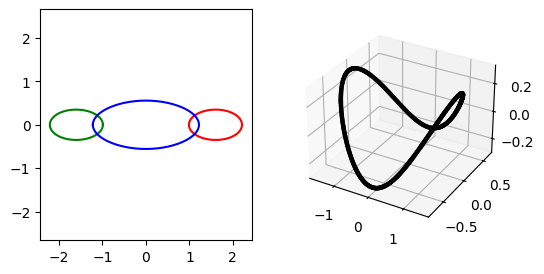

Covariance eigenvalues: 8.4e-01  1.2e-01  3.3e-02  2.0e-03  9.3e-18  -3.6e-16 
Mean distance to origin: 2.8e+00 ± 5.7e-02
Mean distance to origin: 1.0e+00 ± 9.5e-02


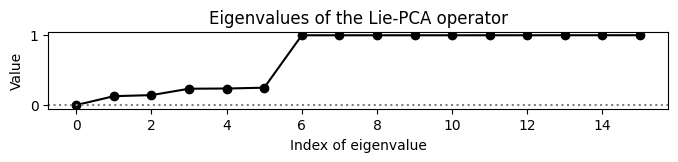

Optimal frequencies found: ((1, 2),)
Symmetric Hausdorff distance: 0.1713


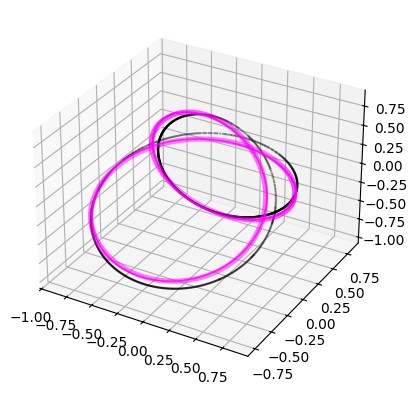

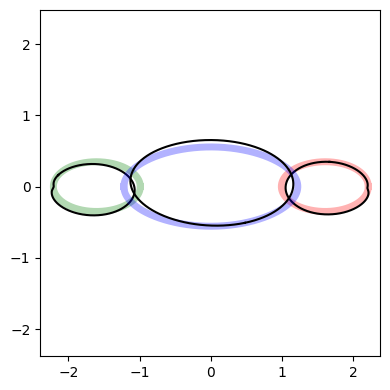


Broucke orbit A2
Integration error (distance between endpoints): 0.0018690256694824737


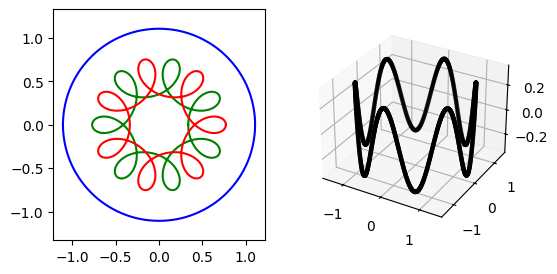

Covariance eigenvalues: 4.8e-01  4.8e-01  2.5e-02  2.5e-02  5.1e-16  1.4e-16 
Mean distance to origin: 1.4e+00 ± 1.1e-04
Mean distance to origin: 1.0e+00 ± 2.0e-03


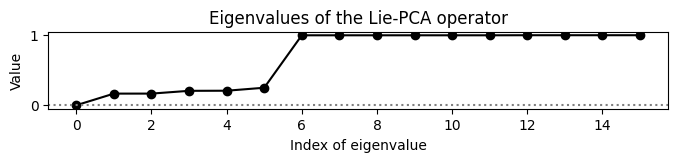

Optimal frequencies found: ((1, 6),)
Symmetric Hausdorff distance: 0.01192


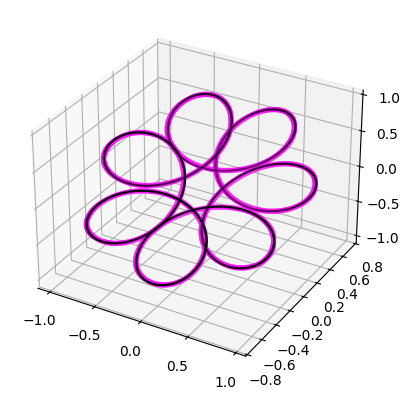

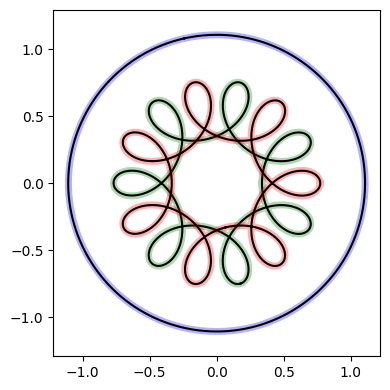


Broucke orbit A3
Integration error (distance between endpoints): 0.00052620032850519


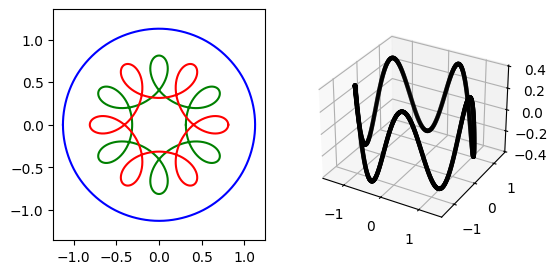

Covariance eigenvalues: 4.7e-01  4.7e-01  3.1e-02  3.1e-02  9.3e-17  -5.3e-18 
Mean distance to origin: 1.4e+00 ± 1.9e-04
Mean distance to origin: 1.0e+00 ± 2.6e-03


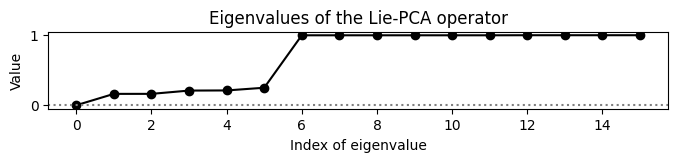

Optimal frequencies found: ((1, 5),)
Symmetric Hausdorff distance: 0.01443


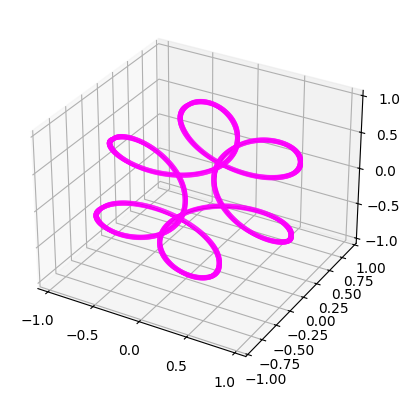

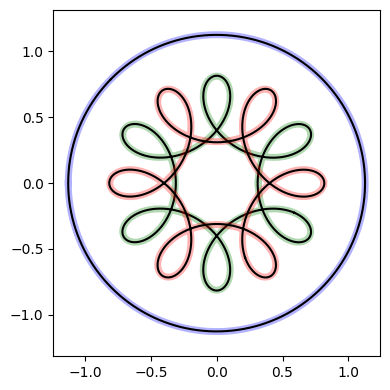


Broucke orbit A7
Integration error (distance between endpoints): 0.0006117338087250755


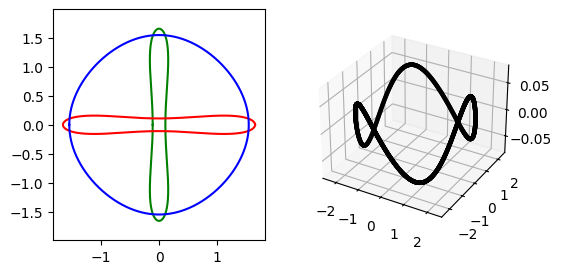

Covariance eigenvalues: 5.0e-01  5.0e-01  3.4e-04  3.4e-04  3.5e-16  4.2e-17 
Mean distance to origin: 2.3e+00 ± 8.5e-03
Mean distance to origin: 1.0e+00 ± 5.6e-02


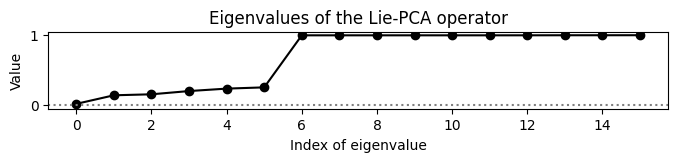

Optimal frequencies found: ((1, 3),)
Symmetric Hausdorff distance: 0.15388


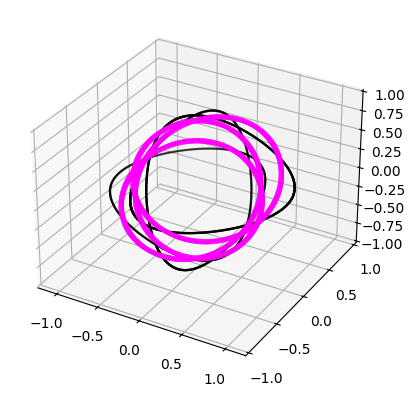

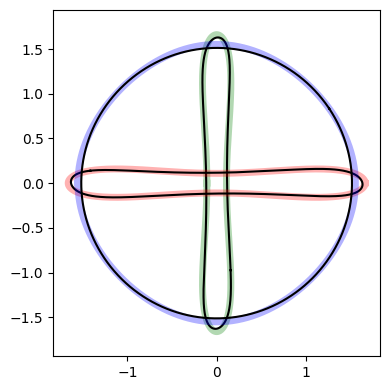


Broucke orbit A11
Integration error (distance between endpoints): 0.00033926702810838083


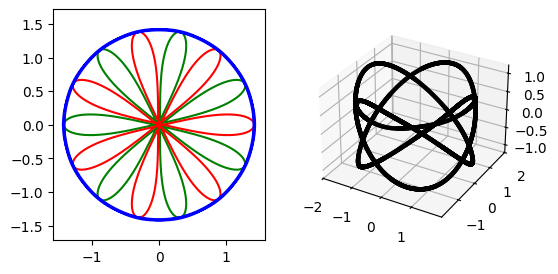

Covariance eigenvalues: 3.7e-01  3.7e-01  1.3e-01  1.3e-01  1.6e-16  -1.6e-16 
Mean distance to origin: 2.0e+00 ± 4.5e-03
Mean distance to origin: 1.0e+00 ± 1.1e-02


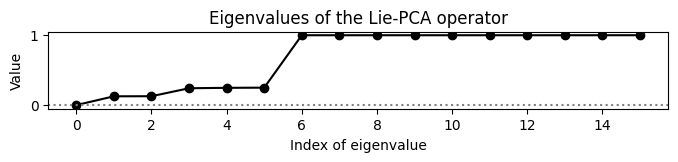

Optimal frequencies found: ((3, 4),)
Symmetric Hausdorff distance: 0.05396


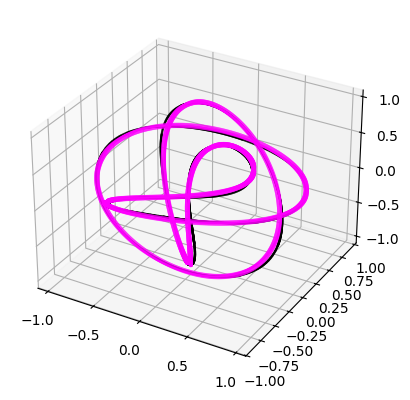

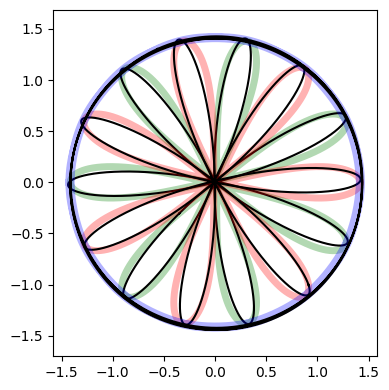


Broucke orbit R1
Integration error (distance between endpoints): 0.0014144194818519799


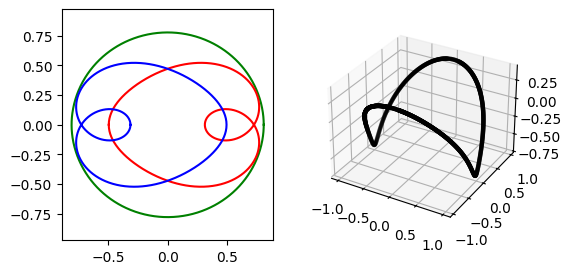

Covariance eigenvalues: 3.4e-01  3.1e-01  2.9e-01  5.3e-02  -1.5e-17  -3.3e-16 
Mean distance to origin: 1.2e+00 ± 1.1e-01
Mean distance to origin: 1.0e+00 ± 1.0e-01


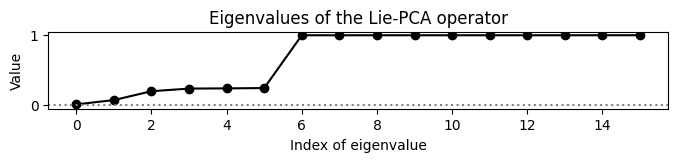

Optimal frequencies found: ((1, 2),)
Symmetric Hausdorff distance: 0.49172


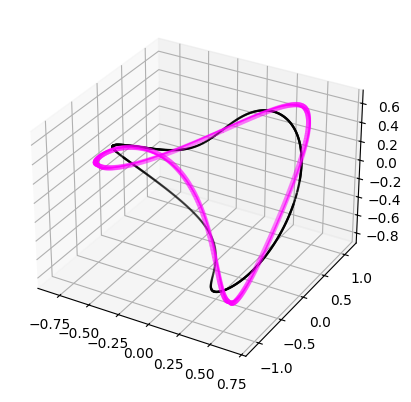

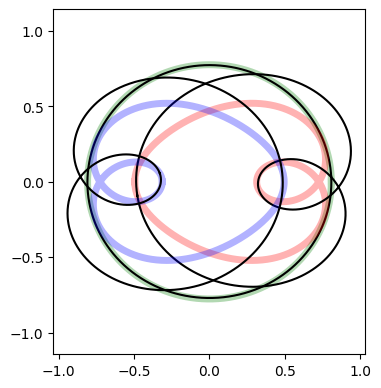


Broucke orbit R2
Integration error (distance between endpoints): 0.00365460306990709


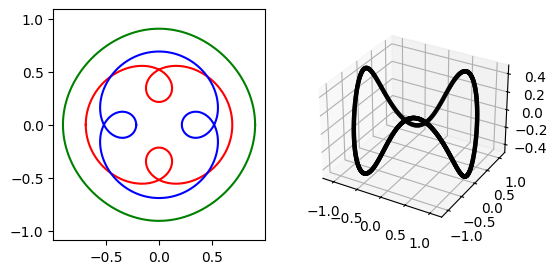

Covariance eigenvalues: 4.4e-01  4.4e-01  5.8e-02  5.8e-02  3.1e-16  -2.5e-16 
Mean distance to origin: 1.2e+00 ± 9.8e-03
Mean distance to origin: 1.0e+00 ± 1.9e-02


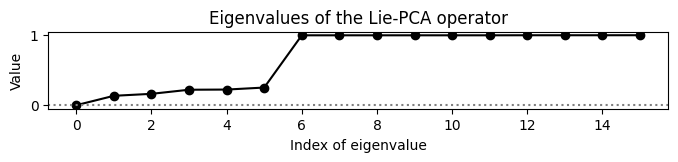

Optimal frequencies found: ((1, 3),)
Symmetric Hausdorff distance: 0.05904


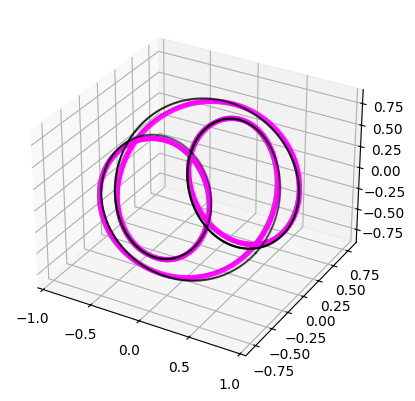

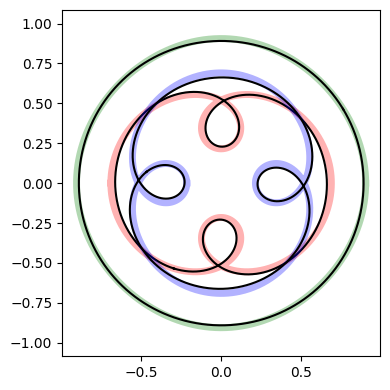


Broucke orbit R9
Integration error (distance between endpoints): 0.0038062869547476133


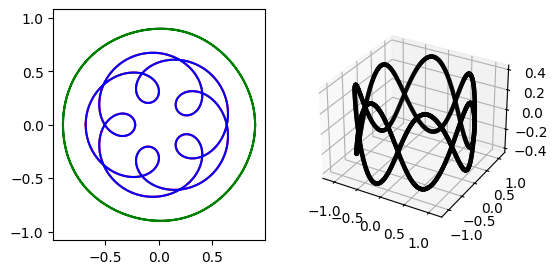

Covariance eigenvalues: 4.5e-01  4.5e-01  4.9e-02  4.9e-02  1.7e-16  -3.7e-16 
Mean distance to origin: 1.2e+00 ± 4.1e-03
Mean distance to origin: 1.0e+00 ± 3.0e-02


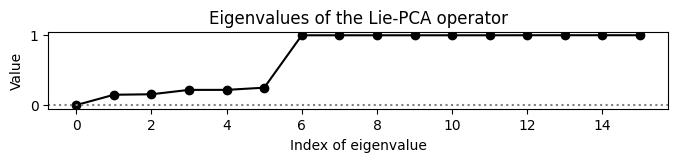

Optimal frequencies found: ((2, 7),)
Symmetric Hausdorff distance: 0.11897


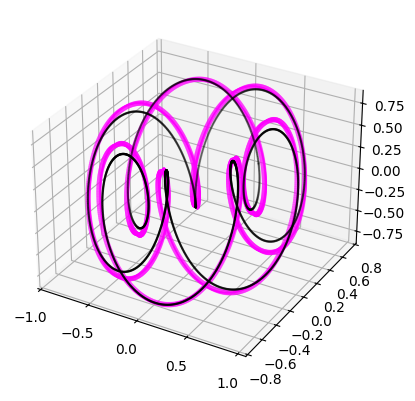

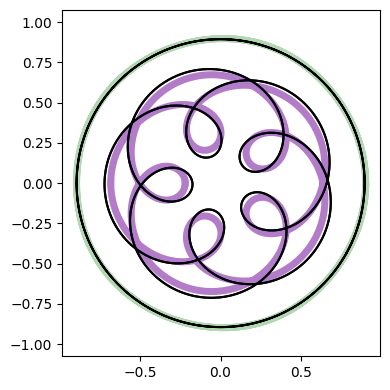


Broucke orbit R12
Integration error (distance between endpoints): 0.0014003299262866319


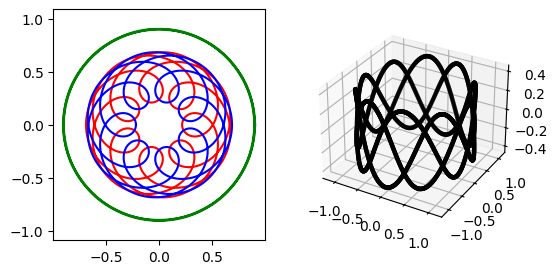

Covariance eigenvalues: 4.5e-01  4.5e-01  5.2e-02  5.2e-02  -1.2e-16  -3.8e-16 
Mean distance to origin: 1.2e+00 ± 5.3e-03
Mean distance to origin: 1.0e+00 ± 3.5e-02


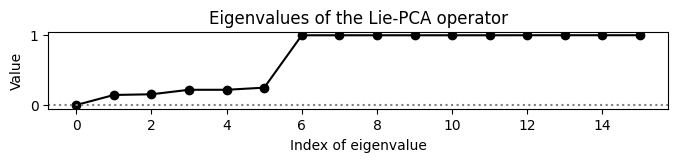

Optimal frequencies found: ((3, 10),)
Symmetric Hausdorff distance: 0.10528


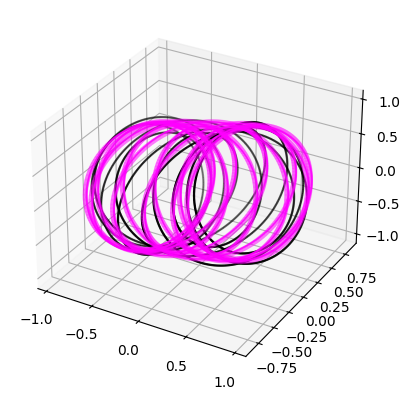

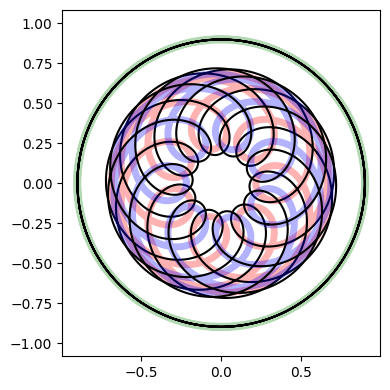

In [4]:
results = []

for name in integration_parameters:
    print("\nBroucke orbit", name)

    # Generate dataset
    time_step, nb_points_subsample, frequency_max = integration_parameters[name]
    initial_conditions, period = broucke_initial_conditions[name]
    pts, solution, integration_error = three_body_trajectory(initial_conditions=initial_conditions, period=period,
                                                             time_step=time_step,
                                                             nb_points_subsample=nb_points_subsample,
                                                             method_space="position")

    # Show covariance eigenvalues.
    print_covariance_eigenvalues(pts)

    # Show distribution of norms.
    print_norms(pts)

    # Reduce dimension.
    ambient_dim = 4
    pca = sklearn.decomposition.PCA(n_components=ambient_dim)
    pts_dim_red = pca.fit_transform(pts)

    # Orthonormalize.
    pts_dim_red, cov = orthonormalize(pts_dim_red)
    print_norms(pts_dim_red)

    # Lie-PCA.
    lie_pca = get_lie_pca_operator(pts=pts_dim_red, nb_neighbors=2, orbit_dim=1, method="PCA", correction=True,
                                   verbose=False)
    vals = np.sort(np.linalg.eigvals(lie_pca).real)
    _, ax = plt.subplots(figsize=(8, 1))
    ax.plot(range(len(vals)), vals, c="black")
    ax.scatter(range(len(vals)), vals, c="black")
    ax.axhline(0, color="grey", linestyle="dotted")
    ax.set_ylim((0 - 0.05, max(vals) + 0.05))
    ax.set_title("Eigenvalues of the Lie-PCA operator")
    ax.set_xlabel("Index of eigenvalue")
    ax.set_ylabel("Value")
    plt.show()

    # LieDetect.
    optimal_rep, optimal_algebra = find_closest_algebra(group="torus", lie_pca=lie_pca, group_dim=1,
                                                        frequency_max=frequency_max, span_ambient_space=True,
                                                        method="abelian", verbose=False)
    print('Optimal frequencies found:', optimal_rep)
    orbit = sample_orbit_from_algebra(group="torus", rep_type=optimal_rep, algebra=optimal_algebra, x=pts_dim_red[0, :],
                                      nb_points=nb_points_subsample, method="uniform", verbose=False, )
    print('Symmetric Hausdorff distance:', round(max(scipy.spatial.distance.directed_hausdorff(pts_dim_red, orbit)[0],
                                                     scipy.spatial.distance.directed_hausdorff(orbit, pts_dim_red)[0]),
        5))

    # Plot estimated orbit
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(projection='3d')
    pts_dim_red_pca = sklearn.decomposition.PCA(n_components=3).fit(pts_dim_red)
    pts_pca = pts_dim_red_pca.transform(pts_dim_red)
    ax.scatter(pts_pca[:, 0], pts_pca[:, 1], pts_pca[:, 2], c='black', s=0.5)
    orbit_pca = pts_dim_red_pca.transform(orbit)
    ax.scatter(orbit_pca[:, 0], orbit_pca[:, 1], orbit_pca[:, 2], c='magenta', lw=0.8, alpha=0.5, marker="3")
    plt.tight_layout()
    plt.show()
    fig.savefig('figures/Broucke_embedding_' + name + '.png', dpi=fig.dpi, bbox_inches='tight')

    # Reconstruct initial orbits and plot (# undo orthonormalization and pca).
    cov_inv = np.linalg.inv(cov)
    orbit_full = pca.inverse_transform(np.array([cov_inv.dot(x) for x in orbit]))
    fig = plt.figure(figsize=(4, 4))
    plt.plot(solution.y[0], solution.y[1], '-g', lw=5, alpha=0.3)
    plt.plot(orbit_full[:, 0], orbit_full[:, 1], color='black')
    plt.plot(solution.y[2], solution.y[3], '-r', lw=5, alpha=0.3)
    plt.plot(orbit_full[:, 2], orbit_full[:, 3], color='black')
    plt.plot(solution.y[4], solution.y[5], '-b', lw=5, alpha=0.3)
    plt.plot(orbit_full[:, 4], orbit_full[:, 5], color='black')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    fig.savefig('figures/Broucke_orbit_' + name + '.png', dpi=fig.dpi, bbox_inches='tight')

    # Save scores
    hausdorff0 = max(scipy.spatial.distance.directed_hausdorff(pts_dim_red, orbit)[0],
                     scipy.spatial.distance.directed_hausdorff(orbit, pts_dim_red)[0])
    hausdorff1 = max(scipy.spatial.distance.directed_hausdorff(pts[:, 0:2], orbit_full[:, 0:2])[0],
                     scipy.spatial.distance.directed_hausdorff(orbit_full[:, 0:2], pts[:, 0:2])[0])
    hausdorff2 = max(scipy.spatial.distance.directed_hausdorff(pts[:, 2:4], orbit_full[:, 2:4])[0],
                     scipy.spatial.distance.directed_hausdorff(orbit_full[:, 2:4], pts[:, 2:4])[0])
    hausdorff3 = max(scipy.spatial.distance.directed_hausdorff(pts[:, 4:6], orbit_full[:, 4:6])[0],
                     scipy.spatial.distance.directed_hausdorff(orbit_full[:, 4:6], pts[:, 4:6])[0])
    msg = rf"""{name} & \begin{{minipage}}{{.3\linewidth}}\vspace{{1mm}}
               \includegraphics[width=1\linewidth]{{Broucke_orbit_{name}.png}}\vspace{{1mm}}\end{{minipage}} &
               \begin{{minipage}}{{.3\linewidth}}\vspace{{1mm}}
               \includegraphics[width=1\linewidth]{{Broucke_embedding_{name}.png}}\vspace{{1mm}}\end{{minipage}} &
               ${optimal_rep[0]}$ &
               \begin{{tabular}}{{@{{}}c@{{}}}}
                 \textcolor{{dartmouthgreen}}{{{round(hausdorff1, 5)}}} \\\\
                 \textcolor{{red}}{{{round(hausdorff2, 5)}}} \\\\
                 \textcolor{{blue}}{{{round(hausdorff3, 5)}}} \\\\
                 \textcolor{{deepmagenta}}{{{round(hausdorff0, 5)}}}
               \end{{tabular}} \\\\ \hline"""
    results.append(msg)

In [5]:
# Print latex table for article
print('\n'.join(results))

A1 & \begin{minipage}{.3\linewidth}\vspace{1mm}
               \includegraphics[width=1\linewidth]{Broucke_orbit_A1.png}\vspace{1mm}\end{minipage} &
               \begin{minipage}{.3\linewidth}\vspace{1mm}
               \includegraphics[width=1\linewidth]{Broucke_embedding_A1.png}\vspace{1mm}\end{minipage} &
               $(1, 2)$ &
               \begin{tabular}{@{}c@{}}
                 \textcolor{dartmouthgreen}{0.08987} \\\\
                 \textcolor{red}{0.06104} \\\\
                 \textcolor{blue}{0.11062} \\\\
                 \textcolor{deepmagenta}{0.1713}
               \end{tabular} \\\\ \hline
A2 & \begin{minipage}{.3\linewidth}\vspace{1mm}
               \includegraphics[width=1\linewidth]{Broucke_orbit_A2.png}\vspace{1mm}\end{minipage} &
               \begin{minipage}{.3\linewidth}\vspace{1mm}
               \includegraphics[width=1\linewidth]{Broucke_embedding_A2.png}\vspace{1mm}\end{minipage} &
               $(1, 6)$ &
               \begin{tabular}{@{}c@{}}
 

# II. Hamiltonian systems

In [6]:
def oscillator_trajectory(nb_points=300, k1=1, k2=2, t_max=3 * 2 * np.pi, x0=1, y0=1):
    """ Generates data for a simulation of two-dimensional harmonic oscillator, with N points, and
    coefficients k1 and k2. The system is released from (x0,y0). """
    times = np.linspace(0, t_max, nb_points)
    pts = np.zeros((nb_points, 4))
    pts[:, 0] = x0 * np.cos(k1 * times)
    pts[:, 1] = -k1 * np.sin(k1 * times)
    pts[:, 2] = y0 * np.cos(k2 * times)
    pts[:, 3] = -k2 * np.sin(k2 * times)
    return pts

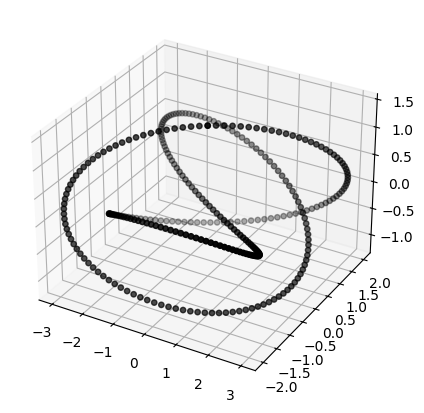

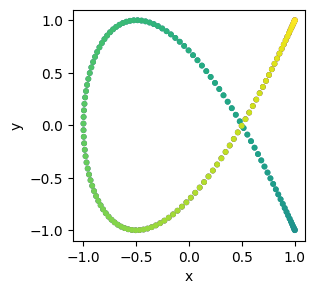

In [7]:
# Makes an oscillator of coefficients k1 = 2 and k2 = 3
pts = oscillator_trajectory(k1=2, k2=3)

# Plot point cloud
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')
pts_pca = sklearn.decomposition.PCA(n_components=3).fit_transform(pts)
ax.scatter(pts_pca[:, 0], pts_pca[:, 1], pts_pca[:, 2], c='black', s=15)
plt.show()

# Plot x and y coordinates of the double oscillator
pts_plot = oscillator_trajectory(k1=2, k2=3, t_max=2 * np.pi)
fig = plt.figure(figsize=(3, 3))
plt.scatter(pts_plot[:, 0], pts_plot[:, 2], cmap='viridis', c=range(len(pts)), s=10)
plt.xlabel('x')
plt.ylabel('y')
fig.savefig('figures/Harmonic_oscillator_1.png', dpi=fig.dpi, bbox_inches='tight');

Covariance eigenvalues: 6.0e-01  2.7e-01  6.7e-02  6.7e-02 
Mean distance to origin: 2.7e+00 ± 5.8e-01
Mean distance to origin: 1.0e+00 ± 2.5e-03


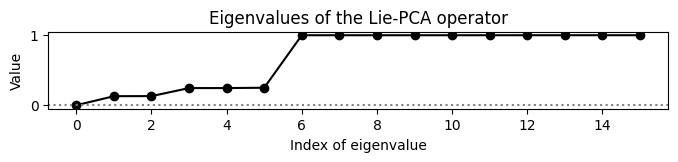

Optimal frequencies found: ((2, 3),)
Symmetric Hausdorff distance: 0.02875


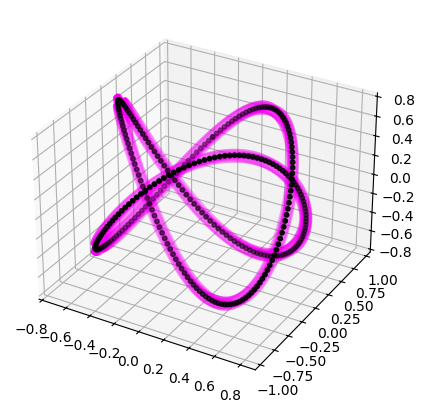

In [8]:
# Show covariance eigenvalues.
print_covariance_eigenvalues(pts)

# Show distribution of norms.
print_norms(pts)

# Reduce dimension.
ambient_dim = 4
pca = sklearn.decomposition.PCA(n_components=ambient_dim)
pts_dim_red = pca.fit_transform(pts)

# Orthonormalize.
pts_dim_red, cov = orthonormalize(pts_dim_red)
print_norms(pts_dim_red)

# Lie-PCA.
lie_pca = get_lie_pca_operator(pts=pts_dim_red, nb_neighbors=2, orbit_dim=1, method="PCA", correction=True,
                               verbose=False)
vals = np.sort(np.linalg.eigvals(lie_pca).real)
_, ax = plt.subplots(figsize=(8, 1))
ax.plot(range(len(vals)), vals, c="black")
ax.scatter(range(len(vals)), vals, c="black")
ax.axhline(0, color="grey", linestyle="dotted")
ax.set_ylim((0 - 0.05, max(vals) + 0.05))
ax.set_title("Eigenvalues of the Lie-PCA operator")
ax.set_xlabel("Index of eigenvalue")
ax.set_ylabel("Value")
plt.show()

# LieDetect.
frequency_max = 10
nb_points = 5000
optimal_rep, optimal_algebra = find_closest_algebra(group="torus", lie_pca=lie_pca, group_dim=1,
                                                    frequency_max=frequency_max, span_ambient_space=True,
                                                    method="abelian", verbose=False)
print('Optimal frequencies found:', optimal_rep)
orbit = sample_orbit_from_algebra(group="torus", rep_type=optimal_rep, algebra=optimal_algebra, x=pts_dim_red[0, :],
                                  nb_points=nb_points, method="uniform", verbose=False, )
print('Symmetric Hausdorff distance:', round(max(scipy.spatial.distance.directed_hausdorff(pts_dim_red, orbit)[0],
                                                 scipy.spatial.distance.directed_hausdorff(orbit, pts_dim_red)[0]),
    5))

# Plot estimated orbit
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": "3d"})
pts_dim_red_pca = sklearn.decomposition.PCA(n_components=3).fit(pts_dim_red)
pts_pca = pts_dim_red_pca.transform(pts_dim_red)
ax.scatter(pts_pca[:, 0], pts_pca[:, 1], pts_pca[:, 2], c='black', s=10)
orbit_pca = pts_dim_red_pca.transform(orbit)
ax.scatter(orbit_pca[:, 0], orbit_pca[:, 1], orbit_pca[:, 2], c='magenta', lw=10, alpha=0.05, marker="3")
fig.savefig('figures/Harmonic_oscillator_2.png', dpi=fig.dpi, bbox_inches='tight')